# AI 편향성 분석 및 완화 실험

이 노트북은 FairFace 데이터셋을 사용하여 AI 모델의 편향성을 다각도로 분석하고, 이를 완화하기 위한 기법을 실험하는 과정을 담고 있습니다.

**실험 목표:**
1.  **Baseline 모델 구축**: 실제 이미지 데이터로 딥러닝 모델(ResNet18)을 학습하고, 기본적인 성능과 그룹별 공정성 지표를 측정합니다.
2.  **Micro-Bias Sensitivity Curve (편향 민감도 곡선) 분석**: 데이터셋에 의도적으로 미세한 편향을 주입했을 때, 모델의 성능과 공정성 지표가 얼마나 민감하게 변하는지 측정하고 시각화합니다.
3.  **Over-Correction Damage Index (ODI, 과보정 피해 지수) 계산**: 공정성 제약을 적용했을 때 발생하는 성능 저하(Trade-off)를 정량적으로 분석합니다.
4.  **Hidden Subgroup Discovery (잠복 하위집단 탐지)**: 전체적으로는 공정해 보이는 모델이 특정 하위집단(e.g., 특정 인종의 특정 연령대)에서 보이는 잠재적 편향을 탐지합니다.

---

## 단계 1: 실험 환경 설정 및 데이터셋 준비

이 단계에서는 실험에 필요한 라이브러리를 임포트하고, FairFace 데이터셋을 불러올 준비를 합니다. 실제 이미지 데이터를 모델이 학습할 수 있는 형태(Tensor)로 변환하는 PyTorch `Dataset`과 `DataLoader`를 정의합니다.


In [1]:
# === 1.1 라이브러리 임포트 ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from PIL import Image
from collections import defaultdict

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# Matplotlib 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu128
CUDA available: False


In [2]:
# === 1.2 주요 설정 (Configuration) ===
# 데이터셋 경로
DATA_DIR = './data/fairface'
TRAIN_LABEL_FILE = os.path.join(DATA_DIR, 'fairface_label_train.csv')
VAL_LABEL_FILE   = os.path.join(DATA_DIR, 'fairface_label_val.csv')

# 이미지 폴더(train/val)도 명시
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
VAL_IMG_DIR   = os.path.join(DATA_DIR, 'val')

# 실험 속성
TARGET_ATTR = 'gender'   # 예측 대상 속성 ('gender' 또는 'race')
SENSITIVE_ATTR = 'race'  # 민감 속성 (편향 분석 기준)

# 학습 하이퍼파라미터 (WSL/CPU 안정 위주)
BATCH_SIZE = 32
NUM_WORKERS = 0                 # WSL/Windows에선 0이 가장 안정적
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 디버그용: 작은 서브셋으로 빠르게 파이프라인 확인
FAST_DEBUG = False              # 필요하면 True로 켜기
DEBUG_SAMPLES_TRAIN = 2000
DEBUG_SAMPLES_VAL   = 400

# 결과 저장
MODEL_SAVE_PATH = 'best_baseline_model.pth'
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Device: {DEVICE}")
print(f"Target Attribute: {TARGET_ATTR}")
print(f"Sensitive Attribute: {SENSITIVE_ATTR}")

Device: cpu
Target Attribute: gender
Sensitive Attribute: race


In [3]:
# === 1.3 FairFace 데이터셋 클래스 정의 ===
class FairFaceDataset(Dataset):
    """FairFace 이미지 데이터셋을 위한 PyTorch Dataset 클래스"""

    def __init__(
        self,
        img_root,
        label_file,
        file_col="file",
        gender_col="gender",
        race_col="race",
        transform=None
    ):
        """
        Args:
            img_root (str): 이미지가 들어있는 디렉터리 (train/ 또는 val/).
            label_file (str): 라벨 CSV 경로.
        """
        self.img_root = Path(img_root).resolve()
        # CSV가 'train/...' 또는 'val/...'를 포함할 수 있으므로 루트 보정
        self.data_root = self.img_root.parent if self.img_root.name in ("train", "val") else self.img_root

        self.file_col = file_col
        self.gender_col = gender_col
        self.race_col = race_col
        self.transform = transform

        try:
            self.labels_df = pd.read_csv(label_file)
        except FileNotFoundError:
            print(f"Error: Label file not found at {label_file}")
            self.labels_df = pd.DataFrame()
            return

        # 라벨 인코딩(항상 정렬)
        self.gender_map = {label: i for i, label in enumerate(sorted(self.labels_df[self.gender_col].unique()))}
        self.race_map   = {label: i for i, label in enumerate(sorted(self.labels_df[self.race_col].unique()))}

        self.idx_to_gender = {v: k for k, v in self.gender_map.items()}
        self.idx_to_race   = {v: k for k, v in self.race_map.items()}

        print(f"Dataset loaded from {label_file}. Number of samples: {len(self.labels_df)}")

    def __len__(self):
        return len(self.labels_df)

    def _resolve_img_path(self, fname: str) -> Path:
        """CSV의 file 값에 'train/' 또는 'val/' 포함 여부에 따라 안전하게 경로 생성"""
        f = str(fname).lstrip("/\\")
        if f.startswith(("train/", "val/")):
            return (self.data_root / f).resolve()
        return (self.img_root / f).resolve()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        row = self.labels_df.iloc[idx]
        img_path = self._resolve_img_path(row[self.file_col])

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            # 누락 파일은 다음 샘플로 스킵
            return self.__getitem__((idx + 1) % len(self))

        # 라벨
        gender = self.gender_map[row[self.gender_col]]
        race   = self.race_map[row[self.race_col]]

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'gender': torch.tensor(gender, dtype=torch.long),
            'race':   torch.tensor(race,   dtype=torch.long),
        }

In [4]:
# === 1.4 데이터 변환 및 데이터로더 생성 ===
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# CPU에서 먼저 파이프라인 확인 시 Augmentation을 최소화해도 좋음
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

if os.path.exists(TRAIN_LABEL_FILE) and os.path.exists(VAL_LABEL_FILE):
    image_datasets = {
        'train': FairFaceDataset(
            img_root=TRAIN_IMG_DIR, label_file=TRAIN_LABEL_FILE,
            file_col="file", gender_col="gender", race_col="race",
            transform=data_transforms['train']
        ),
        'val': FairFaceDataset(
            img_root=VAL_IMG_DIR, label_file=VAL_LABEL_FILE,
            file_col="file", gender_col="gender", race_col="race",
            transform=data_transforms['val']
        )
    }

    # 빠른 확인용 서브셋 옵션
    train_ds = image_datasets['train']
    val_ds   = image_datasets['val']
    if FAST_DEBUG:
        train_ds = Subset(train_ds, list(range(min(DEBUG_SAMPLES_TRAIN, len(train_ds)))))
        val_ds   = Subset(val_ds,   list(range(min(DEBUG_SAMPLES_VAL,   len(val_ds)))))

    dataloaders = {
        'train': DataLoader(
            train_ds, batch_size=BATCH_SIZE, shuffle=True,
            num_workers=NUM_WORKERS, persistent_workers=False
        ),
        'val': DataLoader(
            val_ds, batch_size=BATCH_SIZE, shuffle=False,
            num_workers=NUM_WORKERS, persistent_workers=False
        )
    }

    dataset_sizes = {split: len(dataloaders[split].dataset) for split in ['train', 'val']}
    print("\nDataLoaders created.")
    print(f"Train dataset size: {dataset_sizes['train']}")
    print(f"Validation dataset size: {dataset_sizes['val']}")

    # 한 배치만 꺼내 모양 확인
    batch = next(iter(dataloaders['train']))
    print(f"Sample batch shape: {batch['image'].shape}")
else:
    print("\nError: Could not create DataLoaders.")
    print("Please ensure the label files exist at the specified paths and re-run this cell.")
    dataloaders = None

Dataset loaded from ./data/fairface/fairface_label_train.csv. Number of samples: 86744
Dataset loaded from ./data/fairface/fairface_label_val.csv. Number of samples: 10954

DataLoaders created.
Train dataset size: 86744
Validation dataset size: 10954
Sample batch shape: torch.Size([32, 3, 224, 224])


---
## 단계 2: Baseline 모델 구축 및 학습

이제 데이터 준비가 완료되었으니, 사전 학습된 ResNet18 모델을 기반으로 Baseline 모델을 구축하고 FairFace 데이터셋으로 fine-tuning을 진행합니다.

**수행 작업:**
1.  **모델 정의**: ImageNet으로 사전 학습된 ResNet18 모델을 불러온 후, 우리의 예측 목표(성별 또는 인종 분류)에 맞게 마지막 출력 레이어를 수정합니다.
2.  **학습 함수 정의**: 모델을 지정된 에폭(epoch) 동안 학습하고, 매 에폭마다 검증 데이터셋으로 성능을 평가하는 `train_model` 함수를 정의합니다. 이 함수는 가장 성능이 좋았던 모델의 가중치를 저장합니다.
3.  **모델 학습 실행**: 정의된 함수와 데이터로더를 사용하여 실제로 모델 학습을 시작합니다. 학습 과정에서의 손실(loss)과 정확도(accuracy)가 출력됩니다.


In [5]:
# === 2.1 모델 정의 및 학습/평가 함수 ===

def get_model(num_classes, pretrained=True):
    """
    사전 학습된 ResNet18 모델을 로드하고 fine-tuning을 위해 마지막 레이어를 수정합니다.
    """
    weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.resnet18(weights=weights)
    
    # 마지막 레이어를 제외한 모든 파라미터를 동결 (Feature Extractor로 사용)
    if pretrained:
        for param in model.parameters():
            param.requires_grad = False
        
    # 마지막 Fully Connected Layer를 새로운 레이어로 교체
    # 이 새로운 레이어의 파라미터는 기본적으로 requires_grad=True 입니다.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model.to(DEVICE)


def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    """모델 학습 및 검증을 위한 메인 루프"""
    since = time.time()
    
    # 학습 과정의 손실 및 정확도를 기록할 딕셔너리
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # 각 에폭은 학습과 검증 단계를 거칩니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # tqdm을 사용하여 진행 상황을 시각화합니다.
            for batch in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase"):
                inputs = batch['image'].to(DEVICE)
                labels = batch[TARGET_ATTR].to(DEVICE)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # history에 기록
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # 검증 단계에서 최고 성능 모델 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print(f"** Best validation accuracy updated: {best_acc:.4f}, Model saved to {MODEL_SAVE_PATH}")

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history


def plot_training_history(history):
    """학습 과정의 손실과 정확도 변화를 시각화합니다."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    fig.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'baseline_training_history.png'))
    plt.show()

print("Model and helper functions are defined.")
print("You can now run the next cell to start training the baseline model.")


Model and helper functions are defined.
You can now run the next cell to start training the baseline model.


Baseline model initialized for 2 classes.
Epoch 1/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6324 Acc: 0.6429


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.6120 Acc: 0.6766
** Best validation accuracy updated: 0.6766, Model saved to best_baseline_model.pth
Epoch 2/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6203 Acc: 0.6561


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5559 Acc: 0.7091
** Best validation accuracy updated: 0.7091, Model saved to best_baseline_model.pth
Epoch 3/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6196 Acc: 0.6576


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5628 Acc: 0.7069
Epoch 4/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6230 Acc: 0.6564


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5690 Acc: 0.6938
Epoch 5/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6197 Acc: 0.6581


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5555 Acc: 0.7114
** Best validation accuracy updated: 0.7114, Model saved to best_baseline_model.pth
Epoch 6/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6181 Acc: 0.6588


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5602 Acc: 0.7107
Epoch 7/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6223 Acc: 0.6534


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5967 Acc: 0.6669
Epoch 8/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6225 Acc: 0.6534


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5960 Acc: 0.6917
Epoch 9/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6193 Acc: 0.6568


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5544 Acc: 0.7093
Epoch 10/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6217 Acc: 0.6566


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5677 Acc: 0.7060

Training complete in 1224m 54s
Best val Acc: 0.711430

Plotting training history...


FileNotFoundError: [Errno 2] No such file or directory: 'results/baseline_training_history.png'

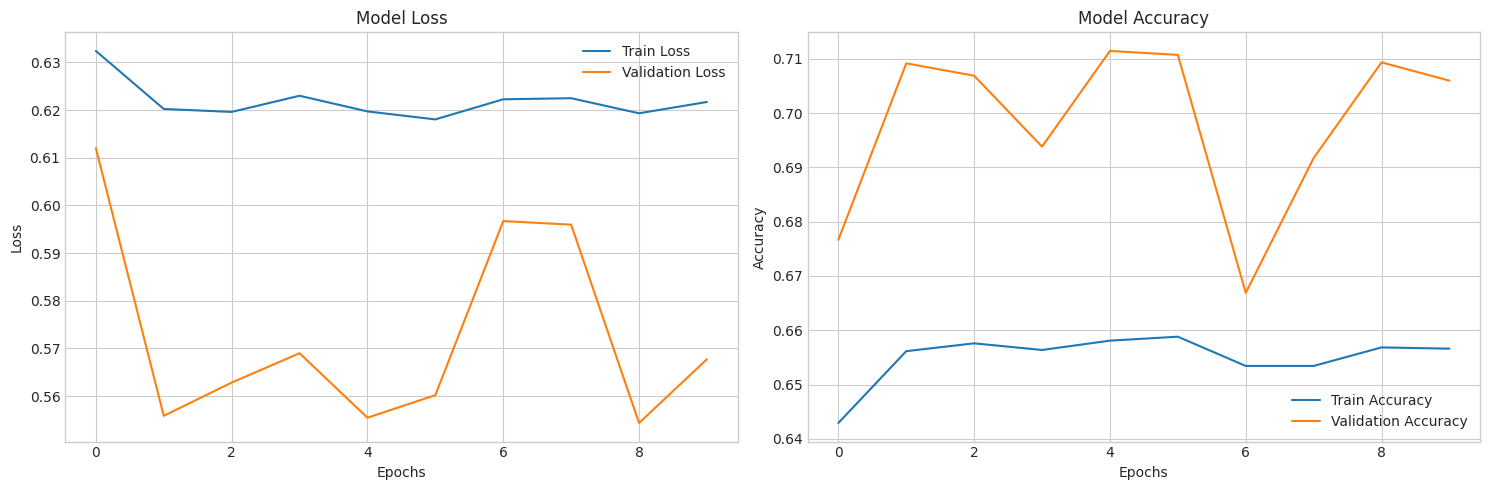

In [6]:
# === 2.2 Baseline 모델 학습 실행 ===

# 데이터로더가 성공적으로 생성되었는지 확인
if dataloaders:
    # train dataset 참조
    train_ds = dataloaders['train'].dataset
    # Subset일 경우 원본 Dataset으로 접근
    if isinstance(train_ds, torch.utils.data.Subset):
        train_ds = train_ds.dataset

    # 타겟 속성에 따른 클래스 수 계산
    if TARGET_ATTR == "gender":
        num_classes = len(train_ds.gender_map)
    elif TARGET_ATTR == "race":
        num_classes = len(train_ds.race_map)
    else:
        raise ValueError(f"Unknown TARGET_ATTR: {TARGET_ATTR}")

    # 모델 초기화
    baseline_model = get_model(num_classes=num_classes, pretrained=True)
    print(f"Baseline model initialized for {num_classes} classes.")

    # 손실 함수 정의
    criterion = nn.CrossEntropyLoss()

    # 옵티마이저 정의 (fc 레이어만 학습)
    optimizer = optim.SGD(baseline_model.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # 모델 학습 시작
    baseline_model, history = train_model(
        baseline_model, criterion, optimizer, dataloaders, num_epochs=NUM_EPOCHS
    )

    # 학습 결과 시각화
    print("\nPlotting training history...")
    plot_training_history(history)

else:
    print("Dataloaders are not available. Cannot start training.")
    print("Please go back to cell 1.4 and ensure the dataset is loaded correctly.")



In [7]:
from pathlib import Path

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)  # 없으면 자동 생성

In [8]:
plt.savefig(RESULTS_DIR / "baseline_training_history.png", dpi=200, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

---
### 단계 2.3: Baseline 모델 성능 및 공정성 평가

모델 학습이 완료되었습니다. 이제 검증 데이터셋(validation set)을 사용하여 학습된 모델의 전반적인 성능과 그룹별 공정성 지표를 평가합니다.

**수행 작업:**
1.  **평가 함수 정의**: 모델의 예측을 받아 전체 정확도, 그룹별 정확도, 그리고 간단한 공정성 지표(정확도 차이, SPD)를 계산하는 함수를 정의합니다.
2.  **성능 평가 실행**: 저장된 베스트 모델을 불러와 검증 데이터셋에 대한 예측을 수행하고, 위 함수를 사용해 결과를 분석합니다.
3.  **결과 시각화**: 그룹별 성능 차이를 막대그래프로 시각화하여 편향성을 직관적으로 확인합니다.


Model loaded from best_baseline_model.pth for evaluation.


Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]


--- Baseline Model Evaluation Results ---
Overall Accuracy: 0.7114
Overall Loss: 0.5555

Group Accuracies:
  - Black: 0.6440 (n=1556)
  - East Asian: 0.7148 (n=1550)
  - Indian: 0.7038 (n=1516)
  - Latino_Hispanic: 0.7012 (n=1623)
  - Middle Eastern: 0.7891 (n=1209)
  - Southeast Asian: 0.7194 (n=1415)
  - White: 0.7223 (n=2085)

Maximum Accuracy Gap: 0.1451


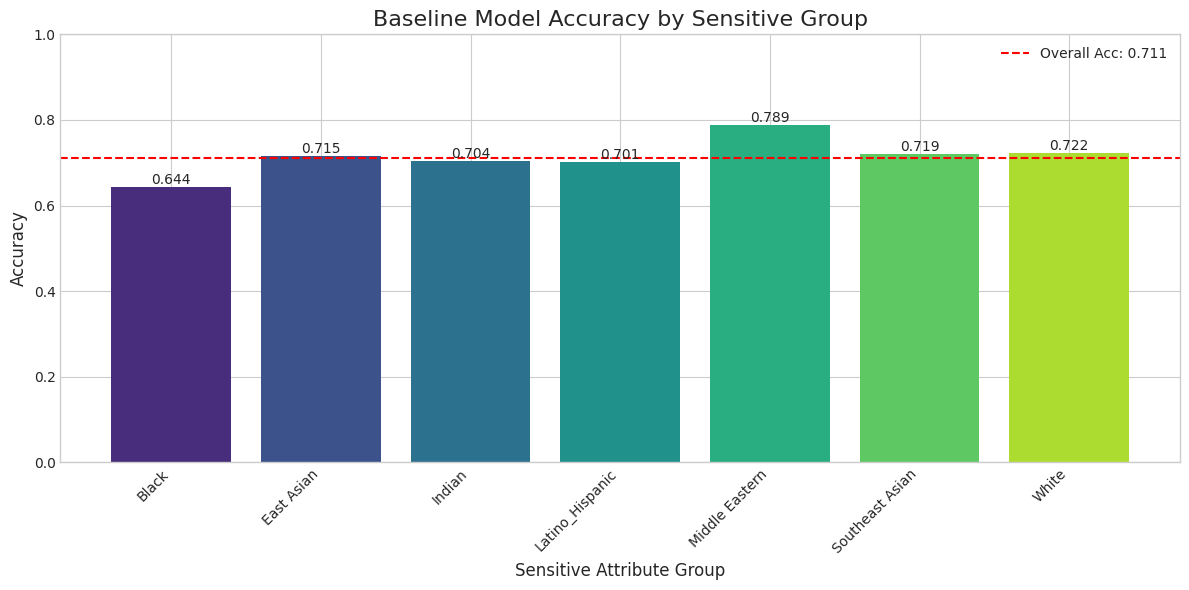

In [12]:
# === 2.3 성능 및 공정성 평가 함수 정의 및 실행 ===

from pathlib import Path, PurePosixPath

def _base_dataset(ds):
    """Subset 등으로 감싸졌을 수도 있는 dataset에서 원본을 안전하게 꺼낸다."""
    return getattr(ds, "dataset", ds)

def evaluate_fairness(model, dataloader, criterion):
    """모델의 성능과 공정성 지표를 상세히 평가하고 결과를 반환합니다."""
    model.eval()
    running_loss = 0.0
    y_true, y_pred, sensitive_attrs = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = batch["image"].to(DEVICE)
            labels = batch[TARGET_ATTR].to(DEVICE)
            s_attrs = batch[SENSITIVE_ATTR].to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            sensitive_attrs.extend(s_attrs.cpu().numpy())

    # numpy 변환
    y_true = np.array(y_true); y_pred = np.array(y_pred); sensitive_attrs = np.array(sensitive_attrs)

    results = {}
    results["overall_loss"] = running_loss / len(dataloader.dataset)
    results["overall_acc"]  = np.mean(y_true == y_pred)

    # 그룹별 성능
    group_accuracies, group_sizes = {}, {}
    base_ds = _base_dataset(dataloader.dataset)
    s_map = base_ds.idx_to_race if SENSITIVE_ATTR == "race" else base_ds.idx_to_gender

    for group_idx, group_name in s_map.items():
        mask = (sensitive_attrs == group_idx)
        if mask.sum() > 0:
            group_accuracies[group_name] = np.mean(y_true[mask] == y_pred[mask])
            group_sizes[group_name] = mask.sum()

    results["group_accuracies"] = group_accuracies
    results["group_sizes"] = group_sizes
    if group_accuracies:
        results["accuracy_gap"] = max(group_accuracies.values()) - min(group_accuracies.values())
    return results


def plot_fairness_results(results):
    """공정성 평가 결과를 시각화합니다."""
    group_accuracies = results["group_accuracies"]
    group_names = list(group_accuracies.keys())
    acc_values  = list(group_accuracies.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(group_names, acc_values, color=sns.color_palette("viridis", len(group_names)))
    plt.title("Baseline Model Accuracy by Sensitive Group", fontsize=16)
    plt.xlabel("Sensitive Attribute Group", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha="right")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.3f}", va="bottom", ha="center")

    plt.axhline(y=results["overall_acc"], color="r", linestyle="--",
                label=f"Overall Acc: {results['overall_acc']:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "baseline_fairness_evaluation.png", dpi=200, bbox_inches="tight")
    plt.show()


# === 평가 실행 ===
if dataloaders:
    # dataloader에서 클래스 수 추출
    base_ds = _base_dataset(dataloaders["train"].dataset)
    if TARGET_ATTR == "race":
        num_classes = len(base_ds.idx_to_race)
    else:  # "gender"
        num_classes = len(base_ds.idx_to_gender)

    model_to_evaluate = get_model(num_classes=num_classes, pretrained=False)
    try:
        state = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
        model_to_evaluate.load_state_dict(state)
        model_to_evaluate.to(DEVICE)  # <- 중요!

        print(f"Model loaded from {MODEL_SAVE_PATH} for evaluation.")

        baseline_results = evaluate_fairness(model_to_evaluate, dataloaders["val"], criterion)

        print("\n--- Baseline Model Evaluation Results ---")
        print(f"Overall Accuracy: {baseline_results['overall_acc']:.4f}")
        print(f"Overall Loss: {baseline_results['overall_loss']:.4f}")
        print("\nGroup Accuracies:")
        for group, acc in baseline_results["group_accuracies"].items():
            print(f"  - {group}: {acc:.4f} (n={baseline_results['group_sizes'][group]})")
        print(f"\nMaximum Accuracy Gap: {baseline_results.get('accuracy_gap', 0):.4f}")

        plot_fairness_results(baseline_results)

    except FileNotFoundError:
        print(f"Error: Saved model not found at {MODEL_SAVE_PATH}. Please run the training cell first.")
else:
    print("Dataloaders not available. Cannot run evaluation.")



---
## 단계 3: Micro-Bias Sensitivity Curve (편향 민감도 곡선) 분석

Baseline 모델의 성능 평가를 마쳤습니다. 이제 이 모델이 데이터셋의 미세한 편향 변화에 얼마나 민감하게 반응하는지를 측정합니다.

**실험 목표:**
"데이터가 전반적으로 공정해 보여도, 특정 그룹의 비율이 아주 약간만 변해도 모델의 예측이 크게 영향을 받는가?"라는 질문에 답하는 것입니다. 이를 통해 모델의 안정성과 잠재적 편향성을 더 깊이 이해할 수 있습니다.

**수행 작업:**
1.  **편향 주입 샘플러(`BiasedSampler`) 정의**: 검증 데이터셋에서 특정 그룹(예: 'White' 인종) 내의 특정 클래스(예: 'Male' 성별) 비율을 원하는 만큼 정밀하게 조절하여 데이터를 추출하는 커스텀 `Sampler`를 정의합니다.
2.  **민감도 분석 실행**: 편향 비율을 단계적으로(예: 40% -> 60%) 변화시키면서, 각 단계마다 편향이 주입된 데이터로 모델을 평가합니다. 전체 정확도, 그룹별 정확도, 공정성 지표(SPD)의 변화를 기록합니다.
3.  **결과 시각화**: X축을 '주입된 편향의 강도', Y축을 '성능 및 공정성 지표'로 하는 "편향 민감도 곡선"을 그려, 변화의 추이를 직관적으로 분석합니다.


In [14]:
from torch.utils.data import DataLoader, Sampler
import torch.nn as nn

# === 3.1 편향 주입 샘플러 및 민감도 분석 실행 ===

# --- 실험 설정 ---
BIAS_INJECTION_GROUP = 'White' 
BIAS_INJECTION_TARGET = 'Male'
BIAS_STEPS = np.arange(0.4, 0.75, 0.05)

def _base_dataset(ds):
    return getattr(ds, "dataset", ds)

def _get_labels_df(ds):
    base = _base_dataset(ds)
    for name in ("labels_df", "df", "label_df"):
        if hasattr(base, name):
            return getattr(base, name)
    raise AttributeError("Dataset must have labels DataFrame (labels_df/df/label_df).")

def _get_name_to_idx_maps(ds):
    base = _base_dataset(ds)
    # race
    if hasattr(base, "race_map"):      # name -> idx
        race_map = base.race_map
    else:                              # idx -> name -> invert
        itr = getattr(base, "idx_to_race", {})
        race_map = {name: idx for idx, name in itr.items()}
    # gender
    if hasattr(base, "gender_map"):    # name -> idx
        gender_map = base.gender_map
    else:
        itg = getattr(base, "idx_to_gender", {})
        gender_map = {name: idx for idx, name in itg.items()}
    return race_map, gender_map

class BiasedSampler(Sampler):
    """특정 (group=name, class=name) 비율을 의도적으로 조절하는 샘플러"""
    def __init__(self, dataset, target_group_name, target_class_name, desired_class_ratio_in_group):
        self.dataset = _base_dataset(dataset)
        self.desired_ratio = float(desired_class_ratio_in_group)

        self.race_map, self.gender_map = _get_name_to_idx_maps(dataset)
        self.target_group_idx  = self.race_map[target_group_name]
        self.target_class_idx  = self.gender_map[target_class_name]

        df = _get_labels_df(dataset)

        # df에는 보통 문자열 레이블이 들어있으므로 그대로 사용
        # (만약 정수 인덱스가 들어있다면 아래 두 줄만 해당 컬럼을 이름으로 매핑해주면 됨)
        self.group_indices = df[df[SENSITIVE_ATTR] == target_group_name].index

        target_mask = (df.loc[self.group_indices, TARGET_ATTR] == target_class_name)
        self.target_class_in_group_indices = df.loc[self.group_indices][target_mask].index.tolist()
        self.other_class_in_group_indices  = df.loc[self.group_indices][~target_mask].index.tolist()

        self.other_group_indices = df.index.drop(self.group_indices).tolist()

        self.num_group_samples      = len(self.group_indices)
        self.num_target_class_samples = int(round(self.num_group_samples * self.desired_ratio))
        self.num_other_class_samples  = self.num_group_samples - self.num_target_class_samples

    def __iter__(self):
        # 비율 맞춰 복원추출
        target_samples = np.random.choice(self.target_class_in_group_indices,
                                          self.num_target_class_samples, replace=True)
        other_class_samples = np.random.choice(self.other_class_in_group_indices,
                                               self.num_other_class_samples, replace=True)
        final_indices = np.concatenate([target_samples, other_class_samples, self.other_group_indices])
        np.random.shuffle(final_indices)
        return iter(final_indices.tolist())

    def __len__(self):
        df = _get_labels_df(self.dataset)
        return len(df)

def run_sensitivity_analysis(model, dataset):
    """편향 비율을 바꿔가며 민감도 분석 실행"""
    model.eval()
    out = []
    for ratio in tqdm(BIAS_STEPS, desc="Analyzing Bias Sensitivity"):
        sampler = BiasedSampler(dataset, BIAS_INJECTION_GROUP, BIAS_INJECTION_TARGET, ratio)
        dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
        res = evaluate_fairness(model, dl, nn.CrossEntropyLoss())
        res['bias_ratio'] = float(ratio)
        out.append(res)
    return pd.DataFrame(out)

# --- 분석 실행 ---
# 2.3에서 로드한 모델 객체명을 쓰자: model_to_evaluate (없으면 저장된 가중치 다시 로드)
model_for_analysis = None
if 'model_to_evaluate' in locals():
    model_for_analysis = model_to_evaluate
elif 'MODEL_SAVE_PATH' in locals():
    # 예비 로드
    num_classes = len(_base_dataset(dataloaders['train'].dataset).idx_to_race) if TARGET_ATTR=='race' \
                  else len(_base_dataset(dataloaders['train'].dataset).idx_to_gender)
    model_for_analysis = get_model(num_classes=num_classes, pretrained=False)
    model_for_analysis.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    model_for_analysis.to(DEVICE)

if model_for_analysis is not None:
    print("Starting Micro-Bias Sensitivity Analysis...")
    sensitivity_results_df = run_sensitivity_analysis(model_for_analysis, image_datasets['val'])
    print("Analysis finished.")
    display(sensitivity_results_df[['bias_ratio', 'overall_acc', 'accuracy_gap']].head())
else:
    print("Baseline model not available. Run Step 2 first.")
    sensitivity_results_df = None



Starting Micro-Bias Sensitivity Analysis...


Analyzing Bias Sensitivity:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/343 [00:00<?, ?it/s]

Analysis finished.


,bias_ratio,overall_acc,accuracy_gap
0,0.40,0.714534,0.145123
1,0.45,0.711977,0.145123
2,0.50,0.710882,0.145123
3,0.55,0.712343,0.145123
4,0.60,0.710425,0.145123


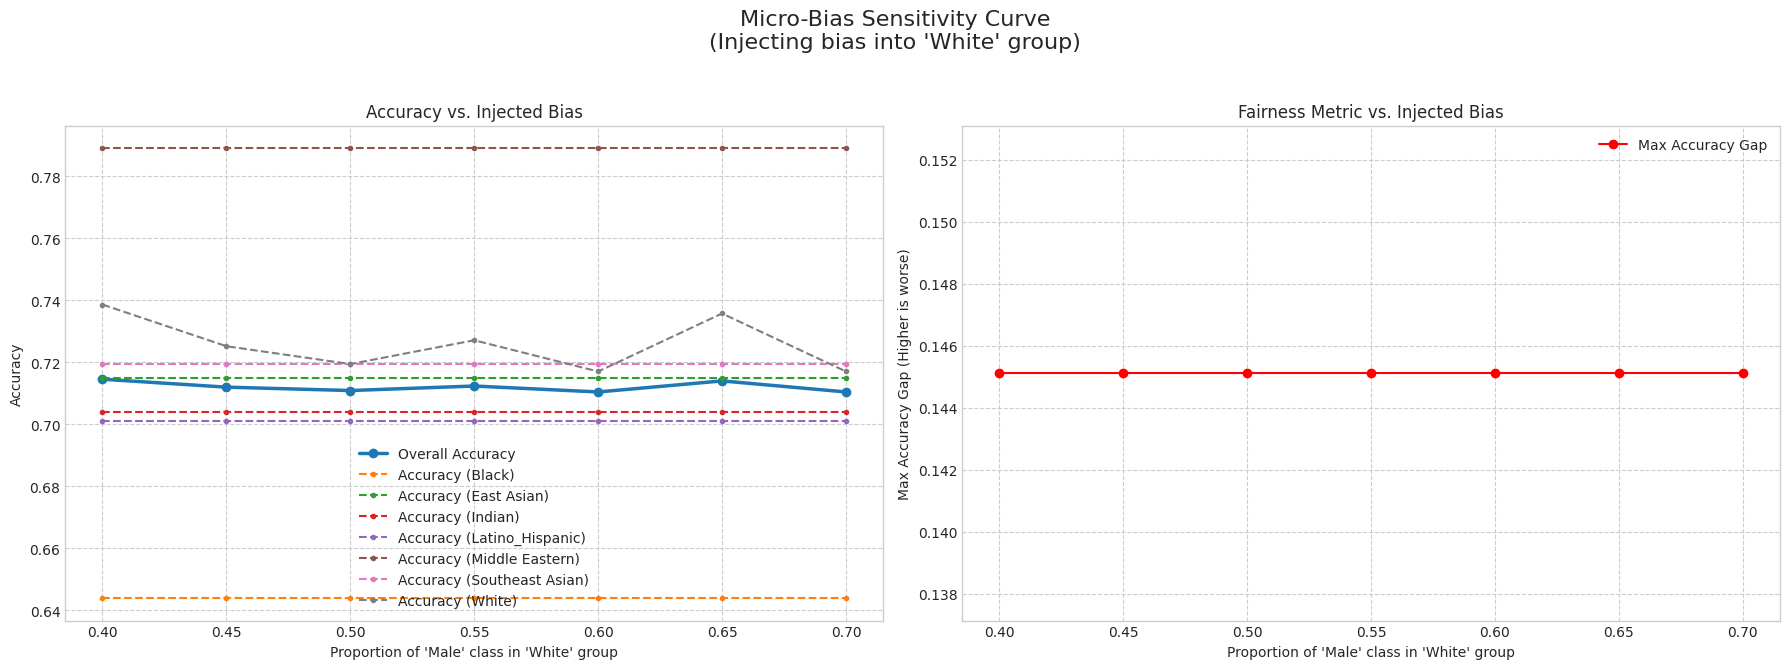

In [15]:
# === 3.2 편향 민감도 곡선 시각화 ===

if sensitivity_results_df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f"Micro-Bias Sensitivity Curve\n(Injecting bias into '{BIAS_INJECTION_GROUP}' group)", fontsize=16)

    # --- 그래프 1: 정확도 변화 ---
    ax1.plot(sensitivity_results_df['bias_ratio'], sensitivity_results_df['overall_acc'], 
             marker='o', linestyle='-', label='Overall Accuracy', linewidth=2.5)
    
    # 그룹별 정확도 변화도 함께 표시
    group_acc_df = sensitivity_results_df['group_accuracies'].apply(pd.Series)
    for group in group_acc_df.columns:
        ax1.plot(sensitivity_results_df['bias_ratio'], group_acc_df[group], 
                 marker='.', linestyle='--', label=f'Accuracy ({group})')

    ax1.set_xlabel(f"Proportion of '{BIAS_INJECTION_TARGET}' class in '{BIAS_INJECTION_GROUP}' group")
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy vs. Injected Bias')
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--')

    # --- 그래프 2: 공정성 지표(정확도 갭) 변화 ---
    ax2.plot(sensitivity_results_df['bias_ratio'], sensitivity_results_df['accuracy_gap'], 
             marker='o', linestyle='-', color='r', label='Max Accuracy Gap')
    
    ax2.set_xlabel(f"Proportion of '{BIAS_INJECTION_TARGET}' class in '{BIAS_INJECTION_GROUP}' group")
    ax2.set_ylabel('Max Accuracy Gap (Higher is worse)')
    ax2.set_title('Fairness Metric vs. Injected Bias')
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(RESULTS_DIR, 'micro_bias_sensitivity_curve.png'))
    plt.show()

else:
    print("Sensitivity analysis results are not available. Please run the previous cell first.")


---
## 단계 4: Over-Correction Damage Index (ODI, 과보정 피해 지수) 분석

편향 완화 기법은 공정성을 높이는 데 도움이 되지만, 종종 모델의 전반적인 성능(정확도)을 하락시키는 Trade-off 관계를 가집니다. 특히 편향이 크지 않은 데이터셋에 과도한 완화 기법을 적용하면, 공정성은 약간 개선되는 반면 성능은 크게 저하될 수 있습니다.

**실험 목표:**
ODI는 **"편향 감소 1단위당 발생하는 성능 손실량"**을 정량화한 지표입니다. 이 지표를 통해 편향 완화 기법 적용의 효율성을 평가하고, '과보정'으로 인한 불필요한 성능 저하 리스크를 측정합니다.

**수행 작업:**
1.  **편향 완화 기법 적용 (Reweighing)**: 학습 데이터셋에서 소수 그룹에 더 높은 가중치를 부여하여 편향을 완화하는 `Reweighing` 기법을 적용합니다. 이를 위해 그룹별 가중치를 계산하고, 가중치가 적용된 `WeightedRandomSampler`를 사용해 모델을 재학습합니다.
2.  **완화 모델 평가**: Reweighing이 적용된 모델의 성능과 공정성 지표를 Baseline 모델과 동일한 방식으로 평가합니다.
3.  **ODI 계산 및 비교**: Baseline 모델과 완화 모델의 성능(정확도) 및 공정성(정확도 갭) 변화량을 측정하고, 이를 바탕으로 ODI를 계산하여 완화 기법의 효율성을 분석합니다.
    -   **ODI = (Accuracy 감소량) / (Accuracy Gap 감소량)**


In [ ]:
# === 4.1 Reweighing 기법 적용 및 ODI 계산 ===
from torch.utils.data import WeightedRandomSampler

def _base_dataset(ds):
    """Subset 등으로 감싸졌을 수 있는 Dataset에서 원본을 꺼냄"""
    return getattr(ds, "dataset", ds)

# --- 1. Reweighing을 위한 가중치 계산 ---
print("--- Step 1: Calculating weights for Reweighing ---")

# 학습 데이터셋의 원본 가져오기
train_ds = _base_dataset(image_datasets['train'])

# Subset 여부에 따라 indices 처리
if hasattr(image_datasets['train'], "indices"):
    train_df = train_ds.labels_df.iloc[image_datasets['train'].indices]
else:
    train_df = train_ds.labels_df

# 민감 속성 그룹별 데이터 수
group_counts = train_df[SENSITIVE_ATTR].value_counts()
num_samples = len(train_df)

# 각 그룹에 대한 가중치 계산 (소수 그룹에 더 높은 가중치)
group_weights = {group: num_samples / (len(group_counts) * count) 
                 for group, count in group_counts.items()}

print("Group counts in training data:\n", group_counts)
print("\nCalculated group weights for sampling:\n", group_weights)

# 학습 데이터셋의 각 샘플에 대한 가중치 할당
sample_weights = train_df[SENSITIVE_ATTR].apply(lambda group: group_weights[group]).to_numpy()
sample_weights = torch.from_numpy(sample_weights).double()

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# 새로운 학습 데이터로더 생성
reweighed_train_loader = DataLoader(
    image_datasets['train'],
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS
)

# 검증 데이터로더는 그대로 사용
reweighed_dataloaders = {'train': reweighed_train_loader, 'val': dataloaders['val']}
print("\nCreated a new train dataloader with WeightedRandomSampler.")


# --- 2. Reweighing 모델 재학습 ---
print("\n--- Step 2: Retraining model with Reweighing ---")

base_ds = _base_dataset(image_datasets['train'])
if TARGET_ATTR == "race":
    num_classes = len(base_ds.idx_to_race)
else:
    num_classes = len(base_ds.idx_to_gender)

reweighed_model = get_model(num_classes=num_classes, pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(reweighed_model.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)

# 재학습 실행
reweighed_model, reweighed_history = train_model(
    reweighed_model, criterion, optimizer,
    reweighed_dataloaders, num_epochs=NUM_EPOCHS
)


# --- 3. 완화 모델 평가 및 ODI 계산 ---
print("\n--- Step 3: Evaluating mitigated model and calculating ODI ---")

# 재학습된 모델 평가
reweighed_results = evaluate_fairness(reweighed_model, dataloaders['val'], criterion)

print("\n--- Reweighed Model Evaluation Results ---")
print(f"Overall Accuracy: {reweighed_results['overall_acc']:.4f}")
print("Group Accuracies:")
for group, acc in reweighed_results['group_accuracies'].items():
    print(f"  - {group}: {acc:.4f}")
print(f"Maximum Accuracy Gap: {reweighed_results.get('accuracy_gap', 0):.4f}")

# ODI 계산
accuracy_drop = baseline_results['overall_acc'] - reweighed_results['overall_acc']
fairness_gain = baseline_results['accuracy_gap'] - reweighed_results['accuracy_gap']

if fairness_gain > 1e-6:
    odi = accuracy_drop / fairness_gain
else:
    odi = float('inf')

print("\n--- Over-Correction Damage Index (ODI) ---")
print(f"Baseline Accuracy: {baseline_results['overall_acc']:.4f}")
print(f"Reweighed Accuracy: {reweighed_results['overall_acc']:.4f}")
print(f"  -> Accuracy Drop: {accuracy_drop:.4f}")
print("-" * 20)
print(f"Baseline Accuracy Gap: {baseline_results['accuracy_gap']:.4f}")
print(f"Reweighed Accuracy Gap: {reweighed_results['accuracy_gap']:.4f}")
print(f"  -> Fairness Gain (Gap Reduction): {fairness_gain:.4f}")
print("-" * 20)
print(f"ODI (Accuracy Drop / Fairness Gain): {odi:.4f}")

if odi > 1.0:
    print("Interpretation: ODI > 1.0 → Accuracy drop이 fairness gain보다 커서 비효율적 (over-correction).")
elif odi >= 0:
    print("Interpretation: 0 <= ODI <= 1.0 → Accuracy drop이 fairness gain보다 작거나 같음 → trade-off 효율적.")
else:
    print("Interpretation: ODI < 0 → Accuracy와 fairness 둘 다 개선됨 (이상적인 케이스).")




--- Step 1: Calculating weights for Reweighing ---
Group counts in training data:
 race
White              16527
Latino_Hispanic    13367
Indian             12319
East Asian         12287
Black              12233
Southeast Asian    10795
Middle Eastern      9216
Name: count, dtype: int64

Calculated group weights for sampling:
 {'White': 0.7498033520905185, 'Latino_Hispanic': 0.9270591755816563, 'Indian': 1.0059258056660443, 'East Asian': 1.0085456173191178, 'Black': 1.012997629363198, 'Southeast Asian': 1.1479388605836036, 'Middle Eastern': 1.3446180555555556}

Created a new train dataloader with WeightedRandomSampler.

--- Step 2: Retraining model with Reweighing ---
Epoch 1/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6265 Acc: 0.6491


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5608 Acc: 0.7068
** Best validation accuracy updated: 0.7068, Model saved to best_baseline_model.pth
Epoch 2/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6185 Acc: 0.6583


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5588 Acc: 0.7132
** Best validation accuracy updated: 0.7132, Model saved to best_baseline_model.pth
Epoch 3/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

Train Loss: 0.6194 Acc: 0.6568


Val Phase:   0%|          | 0/343 [00:00<?, ?it/s]

Val Loss: 0.5527 Acc: 0.7130
Epoch 4/10
----------


Train Phase:   0%|          | 0/2711 [00:00<?, ?it/s]

---
## 단계 5: Hidden Subgroup Discovery (잠복 하위집단 탐지)

지금까지의 분석은 `race`나 `gender`와 같이 단일 속성을 기준으로 편향성을 측정했습니다. 하지만 편향은 여러 속성이 교차하는 더 작은 하위집단(subgroup)에서 증폭되어 나타날 수 있습니다. 예를 들어, 모델이 '흑인 여성' 또는 '동아시아인 남성'과 같이 특정 인종과 성별이 조합된 그룹에서만 유독 낮은 성능을 보일 수 있습니다.

**실험 목표:**
전체 평균이나 단일 그룹별 지표에서는 드러나지 않는 '잠복 편향'을 찾아내는 것입니다. 이를 위해 두 가지 이상의 속성을 조합하여 가능한 모든 하위집단을 만들고, 각 집단에서의 성능을 측정하여 가장 취약한 그룹(worst-performing subgroup)을 식별합니다.

**수행 작업:**
1.  **전체 예측 결과 생성**: Baseline 모델을 사용하여 검증 데이터셋의 모든 샘플에 대한 예측값과 실제값, 그리고 각 샘플의 속성(성별, 인종 등)을 하나의 데이터프레임으로 통합합니다.
2.  **하위집단별 성능 분석**: `race`와 `gender`를 조합하여 생성된 모든 하위집단(예: White-Male, White-Female, Black-Male, ...)에 대해 정확도를 계산합니다.
3.  **결과 시각화 및 분석**: 하위집단별 정확도를 막대그래프로 시각화하고, 전체 평균 정확도와 비교하여 성능이 가장 낮은 최악의 하위집단을 식별합니다. 이를 통해 모델이 어떤 특정 그룹에 취약한지 명확히 파악합니다.


In [ ]:
# === 5.1 잠복 하위집단 분석 실행 ===

def get_predictions_for_subgroup_analysis(model, dataloader):
    """데이터셋 전체에 대한 예측을 수행하고, 라벨 및 속성과 함께 데이터프레임으로 반환합니다."""
    model.eval()
    
    y_true, y_pred, genders, races = [], [], [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions for subgroup analysis"):
            inputs = batch['image'].to(DEVICE)
            
            # 예측 대상 속성에 따른 실제 라벨
            true_labels = batch[TARGET_ATTR].cpu().numpy()
            
            outputs = model(inputs)
            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.cpu().numpy()
            
            # 모든 속성 정보 저장
            y_true.extend(true_labels)
            y_pred.extend(pred_labels)
            genders.extend(batch['gender'].cpu().numpy())
            races.extend(batch['race'].cpu().numpy())
            
    # 숫자 인덱스를 다시 문자열 라벨로 변환
    idx_to_gender = dataloader.dataset.dataset.idx_to_gender
    idx_to_race = dataloader.dataset.dataset.idx_to_race
    
    # 예측 대상 속성에 따라 y_true와 y_pred를 문자열로 변환
    if TARGET_ATTR == 'gender':
        true_labels_str = [idx_to_gender[i] for i in y_true]
        pred_labels_str = [idx_to_gender[i] for i in y_pred]
    else: # race
        true_labels_str = [idx_to_race[i] for i in y_true]
        pred_labels_str = [idx_to_race[i] for i in y_pred]

    # 결과 데이터프레임 생성
    df = pd.DataFrame({
        'true_label': true_labels_str,
        'predicted_label': pred_labels_str,
        'gender': [idx_to_gender[i] for i in genders],
        'race': [idx_to_race[i] for i in races]
    })
    
    df['correct'] = (df['true_label'] == df['predicted_label'])
    
    return df

# --- 분석 실행 ---
if 'baseline_model' in locals() and baseline_model is not None:
    # 1. 전체 예측 결과 생성
    predictions_df = get_predictions_for_subgroup_analysis(baseline_model, dataloaders['val'])

    # 2. 하위집단(race x gender)별 정확도 계산
    subgroup_analysis = predictions_df.groupby(['race', 'gender']).agg(
        accuracy=('correct', 'mean'),
        count=('correct', 'size')
    ).reset_index()

    # 정확도를 기준으로 정렬
    subgroup_analysis = subgroup_analysis.sort_values(by='accuracy', ascending=True)

    print("\n--- Hidden Subgroup Analysis Results (Race x Gender) ---")
    display(subgroup_analysis)

    # 3. 결과 시각화
    plt.figure(figsize=(15, 8))
    
    # 하위집단 이름을 'race-gender' 형태로 만듭니다.
    subgroup_analysis['subgroup'] = subgroup_analysis['race'] + '-' + subgroup_analysis['gender']
    
    bars = sns.barplot(x='accuracy', y='subgroup', data=subgroup_analysis, palette='plasma')
    
    plt.title('Hidden Subgroup Performance (Race x Gender)', fontsize=16)
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('Subgroup', fontsize=12)
    plt.xlim(0, 1.0)
    
    # 전체 평균 정확도를 수직선으로 표시
    overall_acc = predictions_df['correct'].mean()
    plt.axvline(x=overall_acc, color='r', linestyle='--', label=f'Overall Accuracy ({overall_acc:.3f})')
    
    # 막대 옆에 수치 표시
    for p in bars.patches:
        width = p.get_width()
        plt.text(width + 0.01, p.get_y() + p.get_height() / 2.,
                 f'{width:.3f}', va='center')

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'hidden_subgroup_analysis.png'))
    plt.show()

else:
    print("Baseline model not trained or available. Please run Step 2 first.")
